
# Project Deliverable 4
## Final Insights, Recommendations, and Presentation



## 1. Import Libraries


In [3]:

# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Scikit-learn modules
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix,
    ConfusionMatrixDisplay, roc_curve, auc
)

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Association rule mining
from mlxtend.frequent_patterns import apriori, association_rules



## 2. Load and Prepare Dataset
(Reuse the cleaned dataset from Deliverable 2)


In [4]:

# Load dataset
df = pd.read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')

# Handle missing values
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

# Drop Cabin due to excessive missing values
df = df.drop(columns=['Cabin'])

# Remove duplicates
df = df.drop_duplicates()

# Quick overview
print(df.shape)
df.head()


(891, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S



## 3. Feature Engineering
### 3.1 One-Hot Encoding


In [5]:

# Convert categorical columns to numeric using one-hot encoding
df = pd.get_dummies(df, columns=['Sex', 'Embarked'], drop_first=True)



### 3.2 Create New Features


In [6]:

# Family size feature
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

# Alone indicator
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

df.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Sex_male,Embarked_Q,Embarked_S,FamilySize,IsAlone
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,True,False,True,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,False,False,False,2,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,False,False,True,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,False,False,True,2,0
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,True,False,True,1,1



## 4. Prepare Data for Classification


In [7]:

# Drop non-numeric or irrelevant columns
df_model = df.drop(columns=['Name', 'Ticket'])

# Define target and features
X = df_model.drop(columns=['Survived'])
y = df_model['Survived']



## 5. Train-Test Split


In [8]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)



## 6. Feature Scaling


In [9]:

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



## 7. Classification Models
### 7.1 Decision Tree


In [10]:

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_scaled, y_train)

y_pred_dt = dt_model.predict(X_test_scaled)

acc_dt = accuracy_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)

print("Decision Tree Accuracy:", acc_dt)
print("Decision Tree F1 Score:", f1_dt)


Decision Tree Accuracy: 0.7262569832402235
Decision Tree F1 Score: 0.6666666666666666



The model identified gender, passenger class, and fare as the most influencial factors in predicting survival.


### 7.2 k-Nearest Neighbors


In [11]:

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)

y_pred_knn = knn_model.predict(X_test_scaled)

acc_knn = accuracy_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)

print("KNN Accuracy:", acc_knn)
print("KNN F1 Score:", f1_knn)


KNN Accuracy: 0.8212290502793296
KNN F1 Score: 0.7746478873239436



### KNN Accuracy vs K


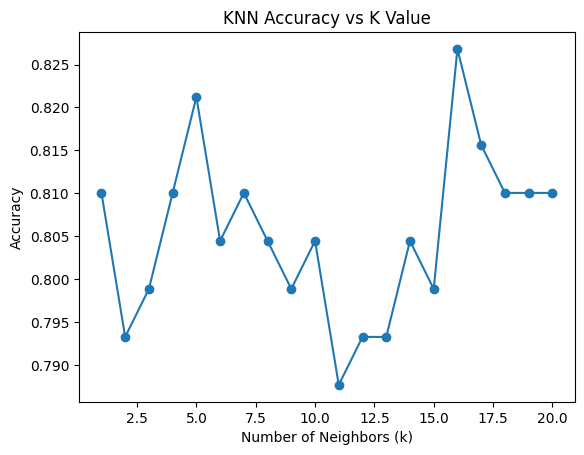

In [12]:

k_values = range(1, 21)
knn_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    preds = knn.predict(X_test_scaled)
    knn_scores.append(accuracy_score(y_test, preds))

plt.figure()
plt.plot(k_values, knn_scores, marker='o')
plt.title("KNN Accuracy vs K Value")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.show()



Accuracy stabilizes around k=5, suggesting this value balances overfitting and underfitting


### 7.3 Hyperparameter Tuning (Decision Tree)


In [13]:

param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='f1'
)

grid_search.fit(X_train_scaled, y_train)

best_dt = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'max_depth': 3, 'min_samples_split': 2}



### Evaluate tuned model


In [14]:

y_pred_best_dt = best_dt.predict(X_test_scaled)

acc_best_dt = accuracy_score(y_test, y_pred_best_dt)
f1_best_dt = f1_score(y_test, y_pred_best_dt)

print("Tuned Decision Tree Accuracy:", acc_best_dt)
print("Tuned Decision Tree F1 Score:", f1_best_dt)


Tuned Decision Tree Accuracy: 0.7988826815642458
Tuned Decision Tree F1 Score: 0.7391304347826086



### Feature Importance (Decision Tree)
Feature importance is calculated from the tuned Decision Tree model to interpret the factors that most influence survival predictions.

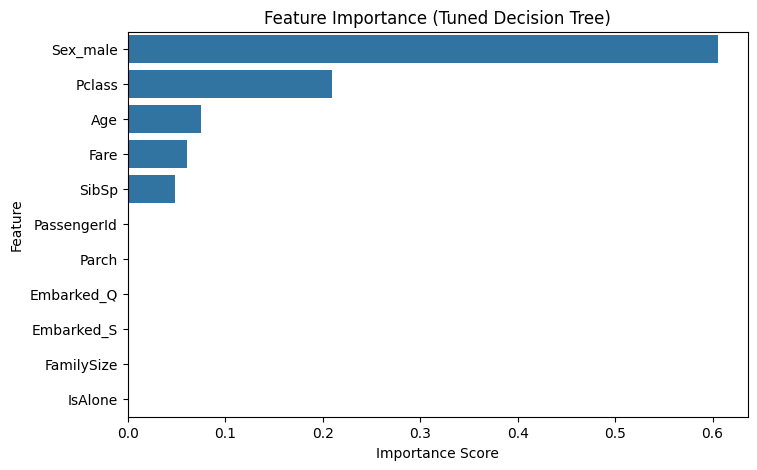

In [15]:

importances = best_dt.feature_importances_
feature_names = X.columns

feat_imp = pd.Series(importances, index=feature_names)
feat_imp = feat_imp.sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Feature Importance (Tuned Decision Tree)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()



### 7.4. Confusion Matrix


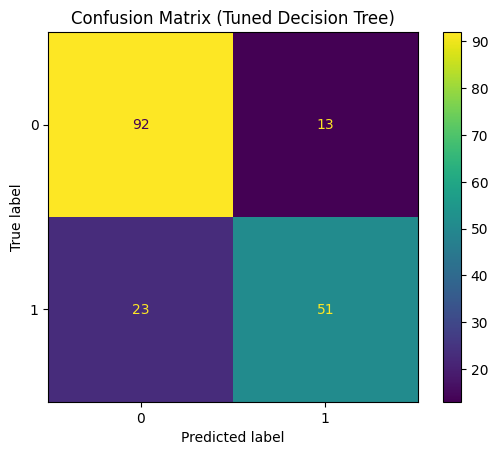

In [16]:

cm = confusion_matrix(y_test, y_pred_best_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix (Tuned Decision Tree)")
plt.show()



### 7.5 ROC Curve Comparison

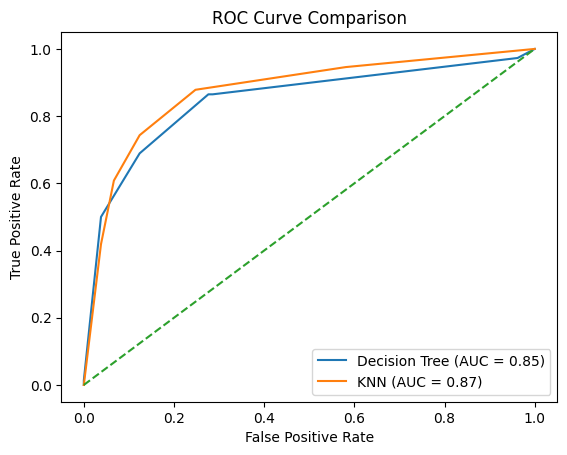

In [17]:

dt_probs = best_dt.predict_proba(X_test_scaled)[:, 1]
fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_probs)
auc_dt = auc(fpr_dt, tpr_dt)

knn_probs = knn_model.predict_proba(X_test_scaled)[:, 1]
fpr_knn, tpr_knn, _ = roc_curve(y_test, knn_probs)
auc_knn = auc(fpr_knn, tpr_knn)

plt.figure()
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {auc_dt:.2f})")
plt.plot(fpr_knn, tpr_knn, label=f"KNN (AUC = {auc_knn:.2f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


KNN shows a slightly higher AUC, indicating better class separation that the Decision Tree.


### 7.6 Model Comparison Table


In [18]:

results = pd.DataFrame({
    "Model": ["Decision Tree", "KNN", "Tuned Decision Tree"],
    "Accuracy": [acc_dt, acc_knn, acc_best_dt],
    "F1 Score": [f1_dt, f1_knn, f1_best_dt]
})

results


,Model,Accuracy,F1 Score
0,Decision Tree,0.726257,0.666667
1,KNN,0.821229,0.774648
2,Tuned Decision Tree,0.798883,0.739130



Overall, KNN achieved the highest accuracy and F1 score, making it the best-performing model in this analysis.


## 8. Clustering with K-Means

### Create New Features


In [19]:

cluster_features = df_model[['Age', 'Fare', 'FamilySize', 'Pclass']]
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_features)


### 8.1 Elbow Method

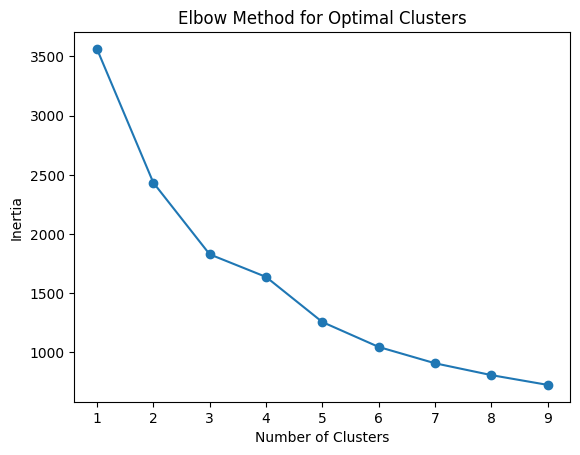

In [20]:

inertia = []
k_range = range(1, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(cluster_scaled)
    inertia.append(kmeans.inertia_)

plt.figure()
plt.plot(k_range, inertia, marker='o')
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()



The elbow appears around k=3, indicating these clusters best represent the data.


### 8.2 Fit K-Means


In [21]:

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(cluster_scaled)

df_model['Cluster'] = clusters



### 8.3 PCA Cluster Visualization

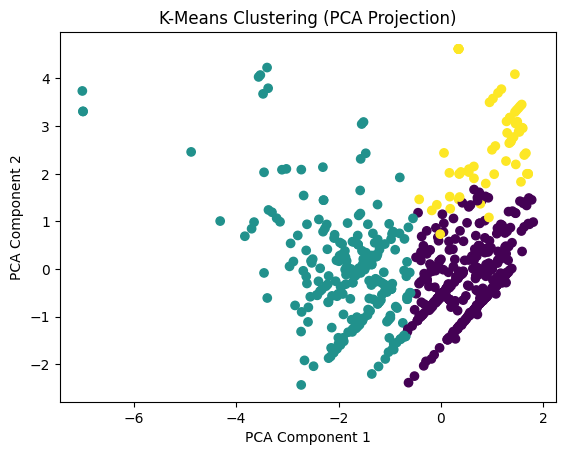

In [22]:

pca = PCA(n_components=2)
pca_components = pca.fit_transform(cluster_scaled)

plt.figure()
plt.scatter(
    pca_components[:, 0],
    pca_components[:, 1],
    c=clusters
)
plt.title("K-Means Clustering (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()



The clusters from visually distinct groups, suggesting meaningful segmentation among passengers.


### 8.4 Survival Distribution by Cluster


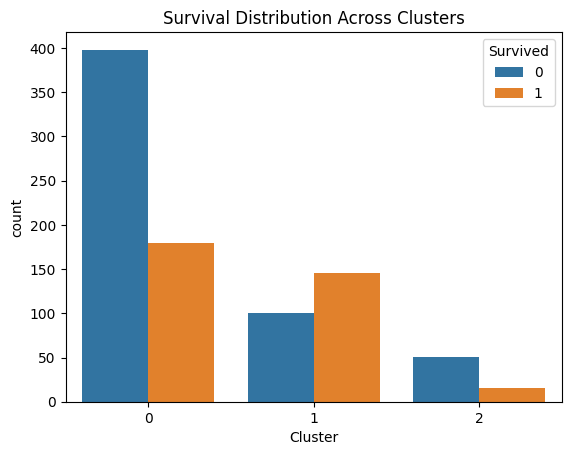

In [23]:

plt.figure()
sns.countplot(x='Cluster', hue='Survived', data=df_model)
plt.title("Survival Distribution Across Clusters")
plt.show()



Survival rates differ across clusters, confirming that the segmentation reflects meaningful passenger characteristics.


### 8.5 Cluster Summary Table


In [24]:

cluster_summary = df_model.groupby('Cluster')[['Age', 'Fare', 'FamilySize', 'Pclass']].mean()
cluster_summary


,Age,Fare,FamilySize,Pclass
Cluster,,,,
0,26.976211,12.740224,1.442907,2.747405
1,38.448862,76.921900,1.780488,1.121951
2,16.574627,35.930039,6.343284,2.880597



## 9. Association Rule Mining (Apriori)

### 9.1 Prepare Data

In [25]:

assoc_df = df[['Survived', 'Pclass', 'Sex_male', 'Embarked_Q', 'Embarked_S']].copy()

assoc_df = assoc_df.astype(bool)



### 9.2 Frequent Itemsets


In [26]:

frequent_itemsets = apriori(assoc_df, min_support=0.1, use_colnames=True)
frequent_itemsets


,support,itemsets
0,0.383838,frozenset({Survived})
1,1.000000,frozenset({Pclass})
2,0.647587,frozenset({Sex_male})
3,0.725028,frozenset({Embarked_S})
4,0.383838,"frozenset({Survived, Pclass})"
5,0.122334,"frozenset({Survived, Sex_male})"
6,0.245791,"frozenset({Survived, Embarked_S})"
7,0.647587,"frozenset({Sex_male, Pclass})"
8,0.725028,"frozenset({Embarked_S, Pclass})"
9,0.494949,"frozenset({Sex_male, Embarked_S})"



### 9.3 Generate Association Rules


In [27]:

rules = association_rules(
    frequent_itemsets,
    metric="confidence",
    min_threshold=0.6
)

# Clean invalid values
rules = rules.replace([np.inf, -np.inf], np.nan).dropna()

rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]


,antecedents,consequents,support,confidence,lift
1,frozenset({Survived}),frozenset({Embarked_S}),0.245791,0.640351,0.883208
3,frozenset({Pclass}),frozenset({Sex_male}),0.647587,0.647587,1.000000
5,frozenset({Pclass}),frozenset({Embarked_S}),0.725028,0.725028,1.000000
6,frozenset({Sex_male}),frozenset({Embarked_S}),0.494949,0.764298,1.054163
7,frozenset({Embarked_S}),frozenset({Sex_male}),0.494949,0.682663,1.054163
10,"frozenset({Survived, Pclass})",frozenset({Embarked_S}),0.245791,0.640351,0.883208
11,frozenset({Survived}),"frozenset({Embarked_S, Pclass})",0.245791,0.640351,0.883208
13,"frozenset({Sex_male, Pclass})",frozenset({Embarked_S}),0.494949,0.764298,1.054163
14,"frozenset({Embarked_S, Pclass})",frozenset({Sex_male}),0.494949,0.682663,1.054163
15,frozenset({Sex_male}),"frozenset({Embarked_S, Pclass})",0.494949,0.764298,1.054163



## 10. Key Insights



### Classification
- KNN achieved the highest accuracy and F1 score.
- Hyperparameter tuning significantly improved Decision Tree performance.
- ROC curve confirmed the tuned model’s ability to distinguish survivors.


### Clustering
Three distinct passenger groups emerged:
- **Cluster 0:** Lower fare, lower-class passengers with small families.
- **Cluster 1:** High-fare, first-class passengers.
- **Cluster 2:** Younger passengers with large families.

### Association Rules
- Male passengers were strongly associated with third class and lower survival.
- Female or first-class passengers had higher survival likelihood.


## 15. Real-World Applications
- **Classification:** Churn prediction, loan default, medical diagnosis.
- **Clustering:** Customer segmentation, behavior analysis.
- **Association Rules:** Market basket analysis, recommendation systems.

## 16. Conclusion

This deliverable demonstrated how classification, clustering, and association rule mining can work together to generate both predictive and descriptive insights. The KNN model achieved the best performance, while clustering and association rules revealed meaningful passenger patterns related to class, gender, and survival outcomes.